## Ensamble de modelos para predecir precios de acciones

### 1. Instalación de librerías

In [1]:
# Librerías generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.graph_objs as go
import datetime as dt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Librerías LSTM
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# Librerías Skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### 2. Carga y preparación de datos

In [2]:
# Parámetros para acceder lago de datos
silver = './data/silver/stock-prices/'
gold = './data/gold/portfolio-optimization/'
silver_table = 'stock_prices.csv'
gold_table = 'portfolio_optimization.csv'

# Parámetros del modelo
ticker = ['AAPL','MSFT','AMZN','TSLA','GOOGL','GOOG','NVDA','BRK-B','META','UNH'] 
metric_to_predict = 'Adj Close'
days_to_predict = 3 # Short-term future days to predict
pred_span_days = 60 # Set the number of days used for prediction
backward_steps = 180 # Set the backward steps to go from the last observation available
cpu_list = [i for i in ticker]
n_features = len(cpu_list)

# Lectura y transformación de datos
data = pd.read_csv(silver+silver_table)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
df_c = pd.pivot_table(data, values=metric_to_predict, columns=['Ticker'], index=data.index)
df_c = df_c[ticker]

# Construcción de modelo para imputar missing values
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Ajuste de modelo para imputar missing values por ticker
for i in ticker:
      imputer.fit(df_c[[i]])
      df_c[i] = imputer.transform(df_c[[i]]).ravel()

# Extracción de porción de datos a usar
df_train = df_c.iloc[-backward_steps:]
df_test = df_c.iloc[backward_steps:]

def inverse_transform(y):
 y_reshaped = y.reshape(-1, y.shape[-1])
 y_inverse = scaler.inverse_transform(y_reshaped)
 return y_inverse

def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = tf.keras.losses.MeanSquaredError()
 mae_ = tf.keras.losses.MeanAbsoluteError()
 mape_ = tf.keras.losses.MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[cpu_list])
scaled_test = scaler.transform(df_test[cpu_list])
scaled_pred = scaler.transform(df_c[cpu_list])

X_train, y_train = split_sequence(scaled_train, look_back=pred_span_days, forecast_horizon=days_to_predict)
X_test, y_test = split_sequence(scaled_test, look_back=pred_span_days, forecast_horizon=days_to_predict)
X_pred, y_pred = split_sequence(scaled_pred, look_back=pred_span_days, forecast_horizon=days_to_predict)

### 3. Entrenamiento de modelos

In [3]:
# CNN-LSTM
def model2(units, dropout_rate):
    model_enc_dec_cnn = Sequential()
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(pred_span_days, n_features)))
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
    model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
    model_enc_dec_cnn.add(Flatten())
    model_enc_dec_cnn.add(RepeatVector(days_to_predict))
    model_enc_dec_cnn.add(LSTM(units, activation='relu', return_sequences=True))
    model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
    model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
    model_enc_dec_cnn.compile(loss='mse', optimizer='adam')
    return model_enc_dec_cnn

units = 128
epochs = 25
dropout_rate = 0.2
batch_size = 32
validation = 0.05

model_enc_dec_cnn = model2(128,0.2)
model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation)
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)
yhat_inverse = inverse_transform( yhat)
y_test_inverse = inverse_transform(y_test)
evaluate_forecast(y_test_inverse, yhat_inverse)
CNN_LSTM_train = yhat_inverse

Epoch 1/25
4/4 [==============================] - 2s 90ms/step - loss: 0.1679 - val_loss: 0.1465
Epoch 2/25
4/4 [==============================] - 0s 23ms/step - loss: 0.0569 - val_loss: 0.0993
Epoch 3/25
4/4 [==============================] - 0s 21ms/step - loss: 0.0407 - val_loss: 0.0682
Epoch 4/25
4/4 [==============================] - 0s 21ms/step - loss: 0.0311 - val_loss: 0.0491
Epoch 5/25
4/4 [==============================] - 0s 21ms/step - loss: 0.0209 - val_loss: 0.0255
Epoch 6/25
4/4 [==============================] - 0s 25ms/step - loss: 0.0137 - val_loss: 0.0520
Epoch 7/25
4/4 [==============================] - 0s 25ms/step - loss: 0.0113 - val_loss: 0.0362
Epoch 8/25
4/4 [==============================] - 0s 22ms/step - loss: 0.0087 - val_loss: 0.0190
Epoch 9/25
4/4 [==============================] - 0s 23ms/step - loss: 0.0070 - val_loss: 0.0186
Epoch 10/25
4/4 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0178
Epoch 11/25
4/4 [============

In [4]:
# Random forest
forecaster_reg = ForecasterAutoregMultiSeries(
                    regressor          = RandomForestRegressor(random_state=123, bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=10),
                    lags               = 7
                )
forecaster_reg.fit(df_train)
RDM_FRST_train = forecaster_reg.predict(days_to_predict)

In [5]:
# XGBoost
forecaster_xgb = ForecasterAutoregMultiSeries(
                    regressor          = XGBRegressor(random_state=123, learning_rate=0.1, max_depth=3, max_iter=100),
                    lags               = 14
                )
forecaster_xgb.fit(df_train)
XGB_train = forecaster_xgb.predict(days_to_predict)

[20:19:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_iter" } are not used.



In [6]:
# Ensamble

# Cambio de estructura de predicciones
CNN_LSTM_train = list(CNN_LSTM_train[-days_to_predict:].reshape(-1))
RDM_FRST_train = list(RDM_FRST_train.values.reshape(-1))
XGB_train = list(XGB_train.values.reshape(-1))
TEST_train = list(df_test[-days_to_predict:].values.reshape(-1))
preds = np.stack([
    CNN_LSTM_train, RDM_FRST_train, XGB_train
])
preds = pd.DataFrame(preds).transpose()

# Entrenamiento
stacker = LinearRegression()
stacker.fit(X=preds, y=TEST_train)

# Coeficientes del modelo ensamble
stacker.intercept_, stacker.coef_

# Predicción
STCK = stacker.predict(preds)
evaluate_forecast(TEST_train, STCK)

mae: tf.Tensor(2.374151590067703, shape=(), dtype=float64)
mse: tf.Tensor(11.632508706037363, shape=(), dtype=float64)
mape: tf.Tensor(1.1135222772675935, shape=(), dtype=float64)


### 4. Predicción de datos

In [7]:
# Funciones para predecir
def predict(num_prediction, model):
    prediction_list = data[-pred_span_days+1:][metric_to_predict]
    for _ in range(days_to_predict):
        yhat = model_enc_dec_cnn.predict(X_pred, verbose=0)
        yhat_inverse = inverse_transform(yhat)[0]
        prediction_list = np.append(prediction_list, yhat_inverse)
    prediction_list = prediction_list[pred_span_days-1:]
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = data.index[len(data.index)-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [8]:
# CNN-LSTM
def model2(units, dropout_rate):
    model_enc_dec_cnn = Sequential()
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(pred_span_days, n_features)))
    model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
    model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
    model_enc_dec_cnn.add(Flatten())
    model_enc_dec_cnn.add(RepeatVector(days_to_predict))
    model_enc_dec_cnn.add(LSTM(units, activation='relu', return_sequences=True))
    model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
    model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
    model_enc_dec_cnn.compile(loss='mse', optimizer='adam')
    return model_enc_dec_cnn

units = 128
epochs = 25
dropout_rate = 0.2
batch_size = 32
validation = 0.05

model_enc_dec_cnn = model2(128,0.2)
model_enc_dec_cnn.fit(X_pred, y_pred, epochs=epochs, batch_size=batch_size, validation_split=validation)
forecast = predict(days_to_predict, model_enc_dec_cnn)
forecast_dates = predict_dates(days_to_predict)
CNN_LSTM = forecast

Epoch 1/25
148/148 [==============================] - 4s 19ms/step - loss: 0.1321 - val_loss: 0.0970
Epoch 2/25
148/148 [==============================] - 3s 19ms/step - loss: 0.0096 - val_loss: 0.1331
Epoch 3/25
148/148 [==============================] - 3s 19ms/step - loss: 0.0076 - val_loss: 0.1105
Epoch 4/25
148/148 [==============================] - 3s 19ms/step - loss: 0.0059 - val_loss: 0.1047
Epoch 5/25
148/148 [==============================] - 3s 22ms/step - loss: 0.0058 - val_loss: 0.1187
Epoch 6/25
148/148 [==============================] - 3s 21ms/step - loss: 0.0050 - val_loss: 0.1172
Epoch 7/25
148/148 [==============================] - 3s 22ms/step - loss: 0.0048 - val_loss: 0.1036
Epoch 8/25
148/148 [==============================] - 3s 23ms/step - loss: 0.0044 - val_loss: 0.0991
Epoch 9/25
148/148 [==============================] - 3s 23ms/step - loss: 0.0043 - val_loss: 0.1070
Epoch 10/25
148/148 [==============================] - 3s 20ms/step - loss: 0.0041 - val_lo

In [9]:
# Random forest
forecaster_reg = ForecasterAutoregMultiSeries(
                    regressor          = RandomForestRegressor(random_state=123, bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=10),
                    lags               = 7
                )
forecaster_reg.fit(df_c)
RDM_FRST = forecaster_reg.predict(days_to_predict)

In [10]:
# XGBoost
forecaster_xgb = ForecasterAutoregMultiSeries(
                    regressor          = XGBRegressor(random_state=123, learning_rate=0.1, max_depth=3, max_iter=100),
                    lags               = 14
                )
forecaster_xgb.fit(df_c)
XGB = forecaster_xgb.predict(days_to_predict)

[20:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_iter" } are not used.



In [11]:
# Ensamble

# Cambio de estructura de predicciones
RDM_FRST = list(RDM_FRST.values.reshape(-1))
XGB = list(XGB.values.reshape(-1))
preds = np.stack([
    CNN_LSTM, RDM_FRST, XGB
])
preds = pd.DataFrame(preds).transpose()

# Predicción
STCK = stacker.predict(preds)
preds.rename(columns={0:'LSTM',1:'RF',2:'XGB'},inplace=True)
preds['Pred'] = STCK

t = []
for j in range(days_to_predict):
    t.append(cpu_list)

d = []
for i in cpu_list:
    d.append(forecast_dates[1:])

preds['Ticker'] = np.array(t).reshape(-1)
d = np.array(d).reshape(-1)
preds.index = d
preds

,LSTM,RF,XGB,Pred,Ticker
2023-05-20,1.921667,174.387881,175.816025,181.345026,AAPL
2023-05-21,18.704309,317.716670,317.300201,330.303987,MSFT
2023-05-22,2.987086,115.983722,115.145691,118.703785,AMZN
2023-05-20,59.352146,179.050743,177.581757,182.318113,TSLA
2023-05-21,38.928791,122.495335,124.460625,125.561291,GOOGL
2023-05-22,38.318901,123.477090,124.460625,126.092718,GOOG
2023-05-20,2.993384,308.190726,313.353668,323.929507,NVDA
2023-05-21,54.545029,327.082500,329.694122,340.285851,BRK-B
2023-05-22,145.489426,245.562910,243.810318,248.507352,META
2023-05-20,23.753115,477.320757,479.214905,499.078917,UNH


### 5. Actualización de datos predichos en Data Lake

In [12]:
# Lectura de data histórica en capa Silver (ésta junto con la data predicha alimentan la tabla de capa Gold)
slv_data = pd.read_csv(silver+silver_table)
slv_data = slv_data[['Date', 'Adj Close', 'Ticker']]
slv_data['Date'] = pd.to_datetime(slv_data['Date'])
slv_data.set_index('Date', inplace=True)
slv_data

,Adj Close,Ticker
Date,,
2003-05-21,0.270919,AAPL
2003-05-22,0.276838,AAPL
2003-05-23,0.278053,AAPL
2003-05-27,0.286552,AAPL
2003-05-28,0.277446,AAPL
...,...,...
2023-05-15,4136.279785,^GSPC
2023-05-16,4109.899902,^GSPC
2023-05-17,4158.770020,^GSPC


In [13]:
# Preparación de datos predichos a insertar en la tabla
ticker_pred_data = preds[['Pred', 'Ticker']].sort_index().sort_values(by=['Ticker'])
ticker_pred_data.rename(columns={'Pred': 'Adj Close'}, inplace=True)
ticker_pred_data.index.name = 'Date'
ticker_pred_data

,Adj Close,Ticker
Date,,
2023-05-20,181.345026,AAPL
2023-05-21,180.483067,AAPL
2023-05-22,180.097248,AAPL
2023-05-20,119.135728,AMZN
2023-05-21,119.555740,AMZN
2023-05-22,118.703785,AMZN
2023-05-21,340.285851,BRK-B
2023-05-20,337.550261,BRK-B
2023-05-22,338.761493,BRK-B


In [14]:
# Actualización de tabla en capa Gold con los nuevos registros
gld_data = pd.concat([slv_data, ticker_pred_data])
gld_data.to_csv(gold+gold_table)
gld_data

,Adj Close,Ticker
Date,,
2003-05-21,0.270919,AAPL
2003-05-22,0.276838,AAPL
2003-05-23,0.278053,AAPL
2003-05-27,0.286552,AAPL
2003-05-28,0.277446,AAPL
...,...,...
2023-05-20,182.318113,TSLA
2023-05-22,181.559613,TSLA
2023-05-21,501.047071,UNH


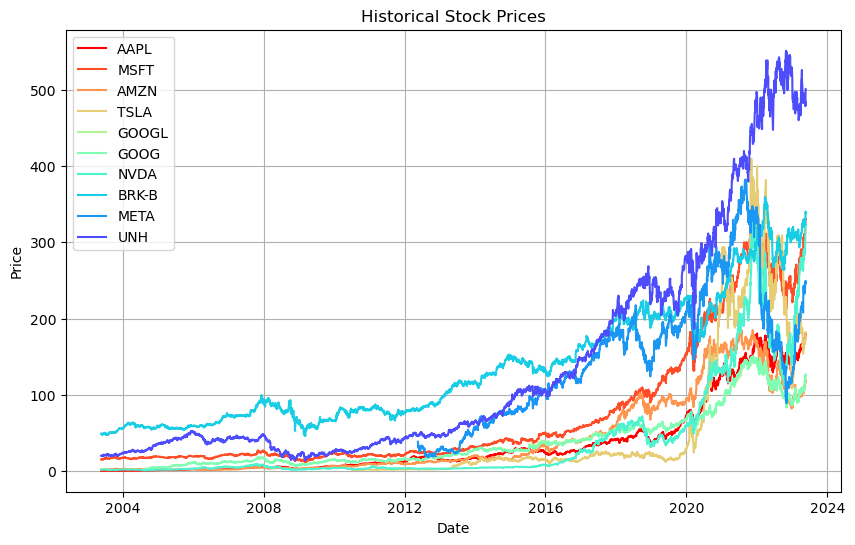

In [15]:
# Graficación de los datos (a manera de validación visual)
def get_data(data, ticker=['AAPL','MSFT','AMZN','TSLA','GOOGL','GOOG','NVDA','BRK-B','META','UNH']):
    input_data = pd.DataFrame()
    for i in ticker:
        ticker_adj_close = data[data['Ticker']==i]['Adj Close']
        input_data = pd.concat((input_data,ticker_adj_close),axis=1)
    input_data.columns = ticker
    input_data.sort_index(inplace=True)
    return input_data

plt_data = get_data (gld_data)
plt.figure(figsize=(10, 6))

num_colors = len(plt_data.columns)
colors = cm.rainbow_r([i / num_colors for i in range(num_colors)])

for i, column in enumerate(plt_data.columns):
    plt.plot(plt_data.index, plt_data[column], label=column, color=colors[i])

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical Stock Prices')
plt.legend()
plt.grid(True)
plt.show()